# Testing the code on simulated signal

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code when running on fake Gaussian noise with a simulated signal injected into it. We run on signals that are progressively larger than the turn-over of a Fermi-Dirac prior to check that the signals can still be recovered, even when well into the exponential tail of the prior.

In [1]:
# import required modules

%matplotlib inline

from __future__ import print_function, division

import numpy as np
import subprocess as sp
import os
import sys
from scipy import optimize
import matplotlib as mpl
from matplotlib import pyplot as pl

# these modules require lalapps
from lalapps.pulsarpputils import *

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [2]:
def fermidirac_rsigma(ul, mufrac=0.4, cdf=0.95):
    """
    Calculate the r and sigma parameter of the Fermi-Dirac distribution to be used.

    Based on the definition of the distribution given in https://www.authorea.com/users/50521/articles/65214/_show_article
    the distribution will be defined by a mu parameter at which the distribution has 50% of it's maximum
    probability, and mufrac which is the fraction of mu defining the range from which the distribution falls from
    97.5% of the maximum down to 2.5%. Using an upper limit defining a given cdf of the distribution the parameters
    r and sigma will be returned.
    """

    Z = 7.33 # factor that defined the 97.5% -> 2.5% probability attenuation band around mu
    r = 0.5*Z/mufrac # set r

    # using the Fermi-Dirac CDF to find sigma given a distribution where the cdf value is found at ul
    solution = optimize.root(lambda s: cdf*np.log(1.+np.exp(r))-np.log(1.+np.exp(-r))-(ul/s)-np.log(1.+np.exp((ul/s)-r)), ul)
    sigma = solution.x[0]

    return r, sigma


In [3]:
# set up the run directories
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadir = os.path.join(rundir, 'data'+detector)
if not os.path.isdir(datadir): # make the directory
    os.makedirs(datadir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O1' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples

## Running the codes

The code is run on random Gaussian noise with zero mean and a given standard deviation. I output a comparison plot between the posteriors produced for each realisation. I compare the upper limit produced from the nested-sampling-generated posterior and that calculated from the grid-based posterior. I also compare the run times for each implementation of the codes.

In [4]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {}
DECJ {}
F0 123.4567890
PEPOCH 56789.0
EPHEM DE405
"""

# some defaults for the data generation
sigma = 1.0e-22        # set data standard deviation
dt = 60                # number of seconds between data points
gpsstart = 900000000   # GPS start time of data
duration = 864000      # duration of data (seconds) - 10 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# get an estimate of the 95% credible upper limit to be expected
ulest = 4.*10.8*np.sqrt(sigma**2/dlen)

r, fdsigma = fermidirac_rsigma(ulest)

h0trues = [ulest*200.]

sigs = []
snropts = []

for h0true in h0trues:
    # create the signal
    pardict = {}
    pardict['h0'] = h0true
    pardict['psi'] = np.pi/4. # set polarisation angle
    pardict['cosiota'] = 0.0 # set inclination
    pardict['phi0'] = 1.3 # set rotational phase

    # set a sky position
    pardict['ra'] = 0.1
    pardict['dec'] = -0.1

    # generate signal
    tssig, sig = heterodyned_pulsar_signal(gpsstart, duration, dt, detector, pardict)
    sigs.append(sig)
    
    # calculate SNR
    snropts.append(get_optimal_snr(sig[0], sigma))

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
# (PHI0 in here is rotational phase, whereas for the older code it is GW phase for trixial emission l=m=2)
priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 fermidirac {} {}
PHI0 uniform 0 {}
PSI uniform {} {}
COSIOTA uniform -1 1
"""
fp = open(priorfile, 'w')
# set the h0 upper range to be 6 times the expected upper limit 
fp.write(priordat.format(fdsigma, r, np.pi, 0.0, np.pi/2.))
fp.close()

# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '1024' # number of nested sample live points

In [5]:
postppens = []

# create noise for data
data = sigma*np.random.randn(dlen, 2)

rah, ram, ras = rad_to_hms(pardict['ra'])
decd, decm, decs = rad_to_dms(pardict['dec'])

# output .par file containing right ascension and declination
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), coord_to_string(decd, decm, decs)))
fp.close()

for sig in sigs:
    # add signal to data
    thisdata = np.copy(data)
    thisdata[:,0] = thisdata[:,0] + sig[0].real
    thisdata[:,1] = thisdata[:,1] + sig[0].imag

    # append times and data together
    tad = np.vstack((gpstimes, thisdata.T)).T

    # output fake data
    datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
    np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')
    
    # run lalapps_pulsar_parameter_estimation_nested
    codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.hdf'),
                     '--gzip', '--Nlive', Nlive, '--Nmcmcinitial', '0', '--oldChunks'])
    p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # nested samples need to be converted to posterior samples with lalapps_nest2pos
    if os.path.isfile(os.path.join(outdir, 'fake_post.hdf')):
        os.remove(os.path.join(outdir, 'fake_post.hdf'))
    codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post.hdf'), os.path.join(outdir, 'fake_nest.hdf')])
    p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()
    
    # get h0 upper limit from 
    post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post.hdf'))

    postppens.append(post)

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'PHI0VECTOR', 'PHI22', 'PEPOCH', 'FREQNUM', 'PHI21', 'C21', 'DEC', 'PMRA', 'HPLUS', 'I31', 'Q22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'PMDEC', 'COSTHETA', 'PX', 'RA', 'df', 'THETA', 'PSIVECTOR', 'F0_FIXED', 'HVECTORY', 'HVECTORX', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: overflow encountered in exp


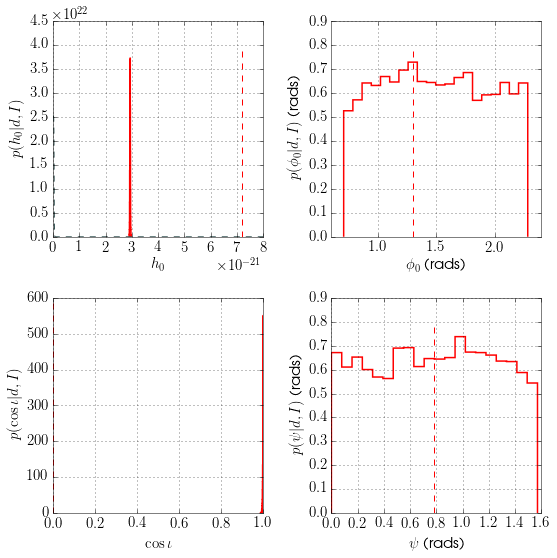

In [6]:
f, axarr = pl.subplots(2, 2, figsize=(8,8))

gridparnames = {'h0': 'h0', 'phi0': 'phi', 'psi': 'psi', 'cosiota': 'ciota'}
xlabels = {'h0': '$h_0$', 'phi0': '$\phi_0$ (rads)', 'cosiota': '$\cos{\iota}$', 'psi': '$\psi$ (rads)'}
ylabels = {'h0': '$p(h_0|d,I)$', 'phi0': '$p(\phi_0|d,I)$ (rads)', 'cosiota': '$p(\cos{\iota}|d,I)$', 'psi': '$p(\psi|d,I)$ (rads)'}

arr = {'h0': axarr[0, 0], 'phi0': axarr[0,1], 'cosiota': axarr[1,0], 'psi': axarr[1,1]}
lims = {'h0': [0., None], 'phi0': [0., 2.*np.pi], 'cosiota': [-1., 1.], 'psi': [-np.pi/4., np.pi/4.]}
# lalapps_pulsar_parameter_estimation_nested posterior samples

colors = ['r', 'b', 'k']

for i, postppen in enumerate(postppens):
    truths = {'h0': h0trues[i], 'phi0': pardict['phi0'], 'psi': pardict['psi'], 'cosiota': pardict['cosiota']}
    pos = postppens[i]
    
    for par in ['h0', 'phi0', 'psi', 'cosiota']:
        arr[par].hist(pos[par].samples, bins=20, normed=True, color=colors[i], linewidth=1.5, histtype='step')
        arr[par].set_xlabel(xlabels[par])
        arr[par].set_ylabel(ylabels[par])
        ylims = arr[par].get_ylim()
        arr[par].plot([truths[par], truths[par]], ylims, '--', color=colors[i])

valrange = np.linspace(0., arr['h0'].get_xlim()[1], 1000)
mu = fdsigma*r
vals = 1./((fdsigma*np.log(1.+np.exp(r)))*(np.exp((valrange-mu)/fdsigma)+1.))
arr['h0'].plot(valrange, vals, '--', color='darkslategrey')
arr['h0'].set_xlim([0., valrange[-1]])

pl.tight_layout()

In [7]:
snropts

[1028.8336640799221]